In [1]:
from astro.load import Loader, GroupSessionData
from astro.preprocess import Preprocessor, GroupedEventPreprocessor
from astro.transforms import GroupSplitter

from astro.decoding_alltime import (
    ATDecodePreprocessor,
    latency_mask_factory,
    ModelFitterCV,
    ModelFitterFrac,
    all_time_decode_block,
    RunResults,
    ConfigTemplate,
    ATDConfig,
    generate_configuration,
    process_atd_config,
)
from astro.decoding_alltime.shuffle import make_shuffle_templates, replicate_template

from trace_minder.preprocess import TracePreprocessor
from trace_minder.align import GroupedAligner
from trace_minder.surrogates import SurrogateTemplate, Rotater, TraceSampler


from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer


from dataclasses import dataclass
from typing import Generator, Callable
import pandas as pd
from astro.decoding_alltime.runner import RunResults


import os
from pathlib import Path
from astro.config import Config

In [2]:
notebook_path = Path(os.getcwd())
root_path = notebook_path.parent.parent
env_path = root_path / ".env"

paths = Config.from_env(env_path)

### Common Processors

In [3]:
loader = Loader(data_dir=paths.data_dir)

In [4]:
trace_preprocessor = TracePreprocessor(
    max_time=600,
    standardize=False,
    medfilt_kernel_size=None,
    resample_frequency=0.1,
)

event_preprocessor = GroupedEventPreprocessor(
    df_events_group_col="mouse_name",
    df_events_event_time_col="start_time",
    first_x_events=5,
)

loader_preprocessor_first5 = Preprocessor(
    trace_preprocessor=trace_preprocessor,
    grouped_event_preprocessor=event_preprocessor,
)

In [5]:
trace_preprocessor = TracePreprocessor(
    min_time=1200,
    standardize=False,
    medfilt_kernel_size=None,
    resample_frequency=0.1,
)

event_preprocessor = GroupedEventPreprocessor(
    df_events_group_col="mouse_name",
    df_events_event_time_col="start_time",
    last_x_events=5,
)

loader_preprocessor_last5 = Preprocessor(
    trace_preprocessor=trace_preprocessor,
    grouped_event_preprocessor=event_preprocessor,
)

In [6]:
group_splitter = GroupSplitter(
    df_mice=loader.load_mice(),
    df_neurons=loader.load_neurons(),
    df_traces_time_col="time",
    excluded_groups=["VEH-VEH"],
    df_neurons_mouse_col="mouse_name",
    df_mice_mouse_col="mouse_name",
    df_neurons_neuron_col="cell_id",
    df_mice_group_col="group",
)

In [7]:
initial_aligner = GroupedAligner(
    t_before=30,
    t_after=30,
    df_wide_group_mapper=group_splitter.neurons_by_mouse(),
    df_events_event_time_col="start_time",
    df_events_group_col="mouse_name",
)

In [8]:
atd_preprocessor_5sec = ATDecodePreprocessor(
    aligner=initial_aligner,
    latency_in_block=latency_mask_factory(-5, 0),
    latency_out_of_block=latency_mask_factory(0, 5),
)

### All Neurons

In [9]:
from sklearn.model_selection import KFold, GroupKFold, LeaveOneGroupOut


def clf_fac_all_neurons():
    return Pipeline(
        [
            ("imputer", SimpleImputer()),
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(solver="saga", max_iter=1000)),
        ]
    )


def model_fitter_fac(frac=0.5):
    return ModelFitterFrac(metric=f1_score, train_frac=frac)


def model_fitter_cv():
    return ModelFitterCV(metric=f1_score, cv=KFold(n_splites=5, shuffle=False))


def model_fitter_grouped_cv():
    return ModelFitterCV(metric=f1_score, cv=GroupKFold(n_splites=5))


def group_getter(df_temp, df_aligned, df_target):
    return df_temp["event_idx"].values

In [16]:
templates = [
    ConfigTemplate(
        data_dir=paths.data_dir,
        session_name="ret",
        group="VEH-CNO",
        group_splitter=group_splitter,
        loader_preprocessor=loader_preprocessor_first5,
        block_group="CS",
        atd_preprocessor=atd_preprocessor_5sec,
        model_factory=clf_fac_all_neurons,
        model_fitter=model_fitter_fac,
    ),
    ConfigTemplate(
        data_dir=paths.data_dir,
        session_name="ret",
        group="CNO-VEH",
        group_splitter=group_splitter,
        loader_preprocessor=loader_preprocessor_first5,
        block_group="CS",
        atd_preprocessor=atd_preprocessor_5sec,
        model_factory=clf_fac_all_neurons,
        model_fitter=model_fitter_fac,
    ),
]

In [27]:
from tqdm.notebook import tqdm


res = []


for template in tqdm(templates):
    # generate samples with replacement
    surrogate_template_set = make_shuffle_templates(
        template=template,
        n=50,
        surrogate_factory=lambda: SurrogateTemplate(
            sampler=TraceSampler(frac_retained=1, with_replacement=True)
        ),
    )

    for atd_config in generate_configuration(surrogate_template_set):
        run_res = process_atd_config(atd_config)
        res.append(dict(group=template.group, score=run_res.score))

  0%|          | 0/2 [00:00<?, ?it/s]

,group,score
0,VEH-CNO,0.809365
1,VEH-CNO,0.809524
2,VEH-CNO,0.920000


/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

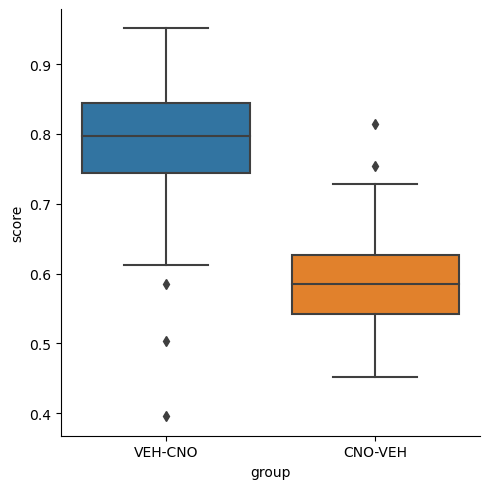

In [28]:
import seaborn as sns
from IPython.display import display, HTML


dfp = pd.DataFrame(res)

display(dfp.head(3))

sns.catplot(data=dfp, x="group", y="score", kind="box")

In [20]:
res[0].__annotations__

{'df_temporal': pandas.core.frame.DataFrame,
 'df_aligned': pandas.core.frame.DataFrame,
 'target_ts': pandas.core.series.Series,
 'clf': sklearn.base.BaseEstimator,
 'le': sklearn.preprocessing._label.LabelEncoder,
 'score': float,
 'desc': str}

In [14]:
from trace_minder.surrogates import Rotater

shuffle_templates = make_shuffle_templates(
    templates[5],
    10,
    surrogate_factory=lambda: SurrogateTemplate(
        sampler=TraceSampler(time_col="time", n_retained=5)
    ),
)
res = []
for atd_config in tqdm(generate_configuration(shuffle_templates)):
    res.append(process_atd_config(atd_config))

0it [00:00, ?it/s]

In [15]:
[r.score for r in res]

[0.4682926829268293,
 0.3537414965986394,
 0.631868131868132,
 0.5945945945945945,
 0.684931506849315,
 0.7093023255813953,
 0.3852459016393443,
 0.26337448559670784,
 0.43884892086330934,
 0.6448979591836734]

In [ ]:
templates = [
    ConfigTemplate(
        data_dir=paths.data_dir,
        session_name="cond",
        group="VEH-CNO",
        group_splitter=group_splitter,
        loader_preprocessor=loader_preprocessor_first5,
        block_group="CS",
        atd_preprocessor=atd_preprocessor_5sec,
        model_factory=clf_fac_all_neurons,
        model_fitter=model_fitter_fac,
    ),
    ConfigTemplate(
        data_dir=paths.data_dir,
        session_name="cond",
        group="CNO-VEH",
        group_splitter=group_splitter,
        loader_preprocessor=loader_preprocessor_first5,
        block_group="CS",
        atd_preprocessor=atd_preprocessor_5sec,
        model_factory=clf_fac_all_neurons,
        model_fitter=model_fitter_fac,
    ),
    ConfigTemplate(
        data_dir=paths.data_dir,
        session_name="ret",
        group="VEH-CNO",
        group_splitter=group_splitter,
        loader_preprocessor=loader_preprocessor_first5,
        block_group="CS",
        atd_preprocessor=atd_preprocessor_5sec,
        model_factory=clf_fac_all_neurons,
        model_fitter=model_fitter_fac,
    ),
    ConfigTemplate(
        data_dir=paths.data_dir,
        session_name="ret",
        group="CNO-VEH",
        group_splitter=group_splitter,
        loader_preprocessor=loader_preprocessor_first5,
        block_group="CS",
        atd_preprocessor=atd_preprocessor_5sec,
        model_factory=clf_fac_all_neurons,
        model_fitter=model_fitter_fac,
    ),
    ConfigTemplate(
        data_dir=paths.data_dir,
        session_name="ext",
        group="VEH-CNO",
        group_splitter=group_splitter,
        loader_preprocessor=loader_preprocessor_first5,
        block_group="CS",
        atd_preprocessor=atd_preprocessor_5sec,
        model_factory=clf_fac_all_neurons,
        model_fitter=model_fitter_fac,
    ),
    ConfigTemplate(
        data_dir=paths.data_dir,
        session_name="ext",
        group="CNO-VEH",
        group_splitter=group_splitter,
        loader_preprocessor=loader_preprocessor_first5,
        block_group="CS",
        atd_preprocessor=atd_preprocessor_5sec,
        model_factory=clf_fac_all_neurons,
        model_fitter=model_fitter_fac,
    ),
    ConfigTemplate(
        data_dir=paths.data_dir,
        session_name="ext",
        group="VEH-CNO",
        group_splitter=group_splitter,
        loader_preprocessor=loader_preprocessor_last5,
        block_group="CS",
        atd_preprocessor=atd_preprocessor_5sec,
        model_factory=clf_fac_all_neurons,
        model_fitter=model_fitter_fac,
    ),
    ConfigTemplate(
        data_dir=paths.data_dir,
        session_name="ext",
        group="CNO-VEH",
        group_splitter=group_splitter,
        loader_preprocessor=loader_preprocessor_last5,
        block_group="CS",
        atd_preprocessor=atd_preprocessor_5sec,
        model_factory=clf_fac_all_neurons,
        model_fitter=model_fitter_fac,
    ),
    ConfigTemplate(
        data_dir=paths.data_dir,
        session_name="diff-ret",
        group="VEH-CNO",
        group_splitter=group_splitter,
        loader_preprocessor=loader_preprocessor_first5,
        block_group="CS",
        atd_preprocessor=atd_preprocessor_5sec,
        model_factory=clf_fac_all_neurons,
        model_fitter=model_fitter_fac,
    ),
    ConfigTemplate(
        data_dir=paths.data_dir,
        session_name="diff-ret",
        group="CNO-VEH",
        group_splitter=group_splitter,
        loader_preprocessor=loader_preprocessor_first5,
        block_group="CS",
        atd_preprocessor=atd_preprocessor_5sec,
        model_factory=clf_fac_all_neurons,
        model_fitter=model_fitter_fac,
    ),
]